# 回帰

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

## 単回帰

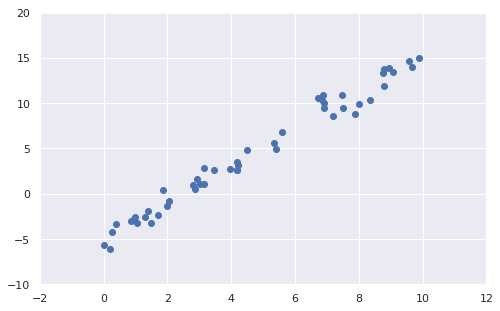

In [81]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)

plt.figure(figsize=(8, 5))
plt.xlim(-2, 12)
plt.ylim(-10, 20)
plt.scatter(x, y)

In [82]:
from sklearn.linear_model import LinearRegression

In [83]:
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

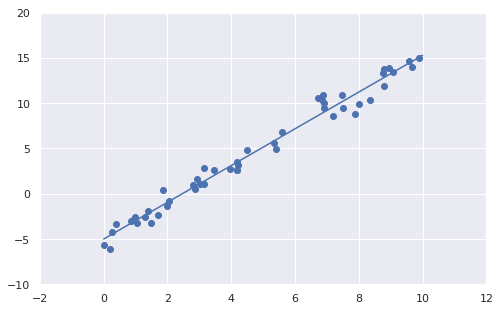

In [84]:
plt.figure(figsize=(8, 5))
plt.xlim(-2, 12)
plt.ylim(-10, 20)
plt.scatter(x, y)
plt.plot(xfit, yfit)

In [85]:
print('Model slope: ', model.coef_)
print('Model intercept: ', model.intercept_)

Model slope:  [2.02720881]
Model intercept:  -4.998577085553204


In [86]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print('Model slope: ', model.coef_)
print('Model intercept: ', model.intercept_)

Model slope:  [ 1.5 -2.   1. ]
Model intercept:  0.50000000000001


## 基底関数回帰

## 多項式基底関数

In [87]:
from sklearn.preprocessing import PolynomialFeatures

In [88]:
X = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(X[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [89]:
from sklearn.pipeline import make_pipeline

In [90]:
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

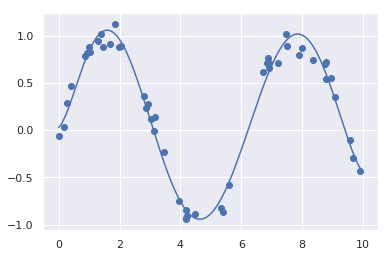

In [91]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

## ガウス基底関数

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

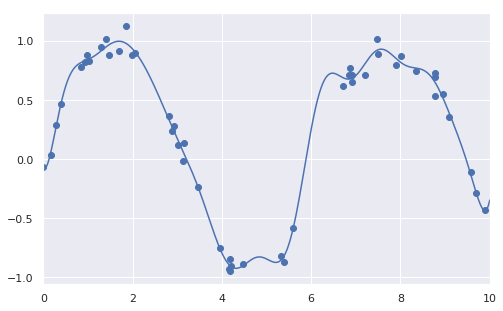

In [93]:
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.figure(figsize=(8, 5))
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

## 正規化

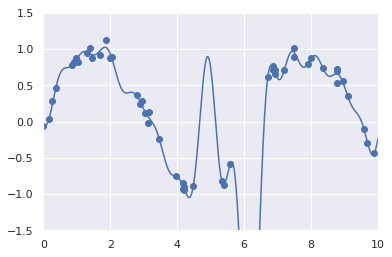

In [94]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

In [95]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))

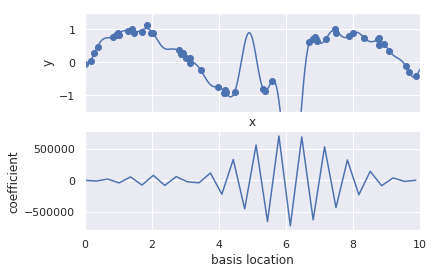

In [96]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

## リッジ回帰(L2)

In [97]:
from sklearn.linear_model import Ridge

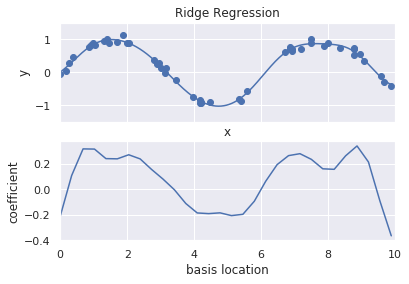

In [98]:
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

## Lasso正規化(L1)

In [99]:
from sklearn.linear_model import Lasso

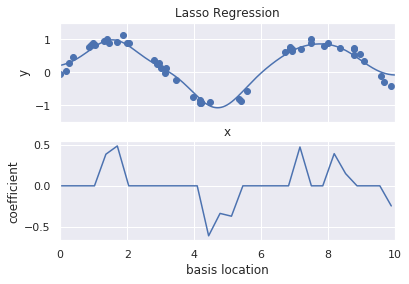

In [100]:
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.01))
basis_plot(model, title='Lasso Regression')

## 自動車の交通量予測

In [101]:
import pandas as pd

In [102]:
import pandas as pd
counts = pd.read_csv('../data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('../data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [103]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

In [104]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [105]:
from pandas.tseries.holiday import USFederalHolidayCalendar

In [106]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [107]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    '''Compute the hours of daylight for the given date
    '''
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

(8, 17)

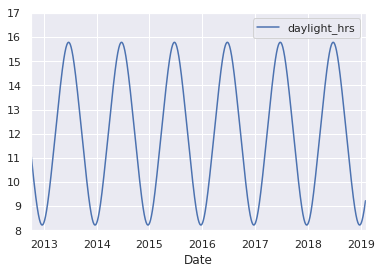

In [108]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [109]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [110]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [111]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [112]:
daily.dropna(axis=0, how='any', inplace=True)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [113]:
X = daily.iloc[:, 1:]
y = daily['Total']

In [114]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

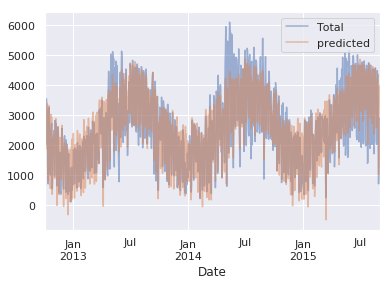

In [115]:
daily[['Total', 'predicted']].plot(alpha=0.5)

In [116]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
Temp (C)          65.162791
dry day          547.698592
annual            26.942713
dtype: float64

In [117]:
from sklearn.utils import resample

In [118]:
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [120]:
pd.DataFrame({
    'effect': params.round(0),
    'error': err.round(0)
})

,effect,error
Mon,505.0,86.0
Tue,610.0,83.0
Wed,593.0,83.0
Thu,482.0,85.0
Fri,178.0,81.0
Sat,-1103.0,80.0
Sun,-1134.0,83.0
holiday,-1187.0,163.0
daylight_hrs,129.0,9.0
PRCP,-665.0,62.0
